# **Motion Deblurring project**

**Raciti Gabriele - 0001102147**

# Data Preparation and Main Function Definitions

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools

We work with images obtained from MNIST.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

11490434/11490434 [==============================] - 2s 0us/step


Generator:

In [ ]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


Plot image function:

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Define the generators and obtain the images (blurred and without blur) :

In [ ]:
train_gen = generator(x_train,100000)
test_gen = generator(x_test, 10000)

train_x,train_y = next(train_gen)
test_x, test_y = next(test_gen)

print(f'train shape: {train_x.shape}')
print(f'test shape: {test_x.shape}')

train shape: (100000, 28, 28)
test shape: (10000, 28, 28)


Set the GPU to use it for speeding up model training:

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    print("Gpu inserted")

Gpu inserted


Set a seed for reproducibility:

In [ ]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the Model

The architecture I chose to use for my project is based on a U-NET architecture. In particular, it consists of 2 encoding layers, a 'bridge' layer, and two decoding layers. Compared to the classic structure seen in class, I decided to make some modifications to the hyperparameters due to the complexity of the model and the relatively small input image size.

In each encoding layer, two identical layers are applied as follows: initially, a convolutional layer with 5x5 filters is applied to capture broader and more complex features within the images (compared to the typical 3x3 filters). In the 2 encoding layers, there are convolutions with 128 filters in the first one and 256 in the second one. After each convolutional layer, the ReLU activation function is applied to introduce non-linearity into the network. Subsequently, BatchNormalization is performed to improve stability. Finally, a 2x2 max-pooling layer reduces the spatial dimension of the feature maps.

Next is the 'bridge' layer, the connection point between the encoder and the decoder. Here, two identical layers are applied as follows: a convolutional layer with 512 filters of size 5x5, followed by the application of the ReLU activation function, and finally BatchNormalization.

Following the 'bridge' layer, there are two decoding layers. At the beginning of each layer, a 2x2 up-sampling operation is applied to gradually restore the size of the feature map. Then, a concatenation is performed between the feature maps obtained from up-sampling and the feature maps coming from the corresponding encoder layer. Afterward, two identical layers are applied as follows:

First, a convolutional layer with 5x5 filters is applied (convolutions with 256 filters in the first layer and 128 in the second). Next, the ReLU activation function is applied to introduce non-linearity. Finally, BatchNormalization is applied to ensure stability.

Finally, an output layer is applied, where a convolutional layer with 1 filter of size 5x5 is applied to the feature maps coming from the decoder. Lastly, a sigmoid activation function is applied to normalize the values between 0 and 1.

Thanks to this U-shaped structure, the model combines the ability to capture broader and more complex features within the images using the 5x5 filters, feature extraction, and the ability to preserve the most relevant features for each pooling region thanks to the 2x2 Max-pooling. It also recovers important details during the decoding process using information from different resolution scales through skip connections that link corresponding layers of the encoder and decoder.

Therefore, it proves to be an excellent choice for problems like deblurring.

I also tried to train simpler models, with the same architecture but different hyperparameters (3x3 kernels and a lower number of filters per layer). They performed well, with naturally shorter training times and a lower number of parameters. However, I decided to use this model because it achieved better MSE results (although the difference was not very significant).

In [ ]:
def build_model():

    input_img = Input(shape=(28, 28, 1))

    # Encoder 1
    x1 = Conv2D(128, (5, 5), padding="same")(input_img)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(128, (5, 5), padding="same")(x1)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    p1 = MaxPooling2D((2, 2))(x1)

    # Encoder 2
    x2 = Conv2D(256, (5, 5), padding="same")(p1)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(256, (5, 5), padding="same")(x2)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    p2 = MaxPooling2D((2, 2))(x2)

    # Bridge
    bridge = Conv2D(512, (5, 5), padding="same")(p2)
    bridge = Activation('relu')(bridge)
    bridge = BatchNormalization()(bridge)
    bridge = Conv2D(512, (5, 5), padding="same")(bridge)
    bridge = Activation('relu')(bridge)
    bridge = BatchNormalization()(bridge)

    # Decoder 1
    d1 = UpSampling2D((2, 2))(bridge)
    d1 = concatenate([d1, x2], axis=-1)
    d1 = Conv2D(256, (5, 5), padding="same")(d1)
    d1 = Activation('relu')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Conv2D(256, (5, 5), padding="same")(d1)
    d1 = Activation('relu')(d1)
    d1 = BatchNormalization()(d1)

    # Decoder 2
    d2 = UpSampling2D((2, 2))(d1)
    d2 = concatenate([d2, x1], axis=-1)
    d2 = Conv2D(128, (5, 5), padding="same")(d2)
    d2 = Activation('relu')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Conv2D(128, (5, 5), padding="same")(d2)
    d2 = Activation('relu')(d2)
    d2 = BatchNormalization()(d2)

    # Output Layer
    output = Conv2D(1, (5, 5), padding="same")(d2)
    output = Activation('sigmoid')(output)

    model = Model(inputs=input_img, outputs=output)

    return model

We can see the model summary:

In [ ]:
model = build_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 128)          3328      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 28, 28, 128)          0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 128)          512       ['activation[0][0]']          
 Normalization)                                                                               

# Train the model

The best values for the hyperparameters regarding the optimizer, number of epochs and batch size for training were obtained through a process of comparing the best performance achieved based on the validation loss. Thanks to the fixed seed for reproducibility, I was able to find the parameter combinations where the validation loss is better. I tried various combinations for them, and these turned out to be the best ones.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(loss='mean_squared_error', optimizer=opt)

model.fit(train_x, train_y, epochs=29, batch_size=32, validation_data=(test_x, test_y))

Epoch 1/29
3125/3125 [==============================] - 111s 34ms/step - loss: 0.0124 - val_loss: 0.0042
Epoch 2/29
3125/3125 [==============================] - 105s 34ms/step - loss: 0.0033 - val_loss: 0.0132
Epoch 3/29
3125/3125 [==============================] - 105s 34ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/29
3125/3125 [==============================] - 105s 34ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/29
3125/3125 [==============================] - 105s 34ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/29
3125/3125 [==============================] - 105s 33ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 7/29
3125/3125 [==============================] - 104s 33ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/29
3125/3125 [==============================] - 105s 34ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/29
3125/3125 [==============================] - 105s 34ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/29
3125/3125 [==============================] 

# Evaluation

Below there are the results obtained by evaluating the model on 10000 blurred versions of the validation set, repeated 10 times. The average MSE result over the 10 rounds is provided, along with the standard deviation.

In [ ]:
mse_scores = []

for i in range(10):
    blurred_images, original_images = next(test_gen)
    test_loss = model.evaluate(blurred_images, original_images)

    mse_scores.append(test_loss)


mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
print(f'Mean MSE: {mean_mse}, Standard Deviation: {std_mse}')


313/313 [==============================] - 4s 14ms/step - loss: 0.0011
Mean MSE: 0.0010706002241931856, Standard Deviation: 1.9447984818459775e-05


# Results

In [ ]:
print(f'Mean MSE: {mean_mse}, Standard Deviation: {std_mse}')

Mean MSE: 0.0010706002241931856, Standard Deviation: 1.9447984818459775e-05


# Plotting example

We display the results of a prediction from the model on 8 blurred images:

In [ ]:
pred_images = model.predict(blurred_images)

313/313 [==============================] - 2s 4ms/step


Plot blurred and predicted images:

8


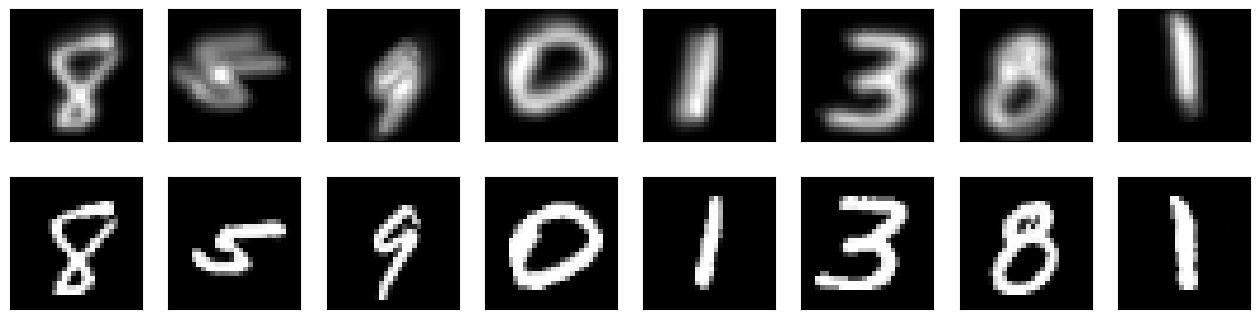

In [ ]:
plot(blurred_images[:8], pred_images[:8])

Plot predicted and original images (for comparison):

8


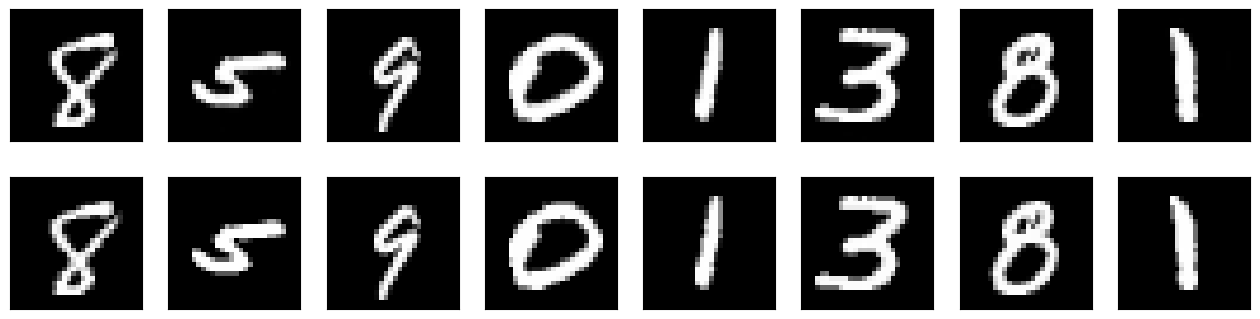

In [ ]:
plot(pred_images[:8], original_images[:8])

# Conclusions

In this project, I tried to create the best model capable of minimizing the MSE between predicted and original images. Basing the model architecture on the U-NET architecture, I was able to achieve excellent results, with a very low MSE value. Thanks to the use of 5x5 filters capable of capturing broader and more complex features, along with the encoder-decoder structure with skip connections that facilitated the preservation and reintegration of crucial information, the model struck a good balance between performance and efficiency, achieving a higher quality of deblurring compared to simpler architectures. However, I have also explored excellent compromises with simpler models with smaller kernels (3x3) and a reduced number of filters per layer (64-128-256 instead of 128-256-512). They have been able to combine in the best possible way speed and results (slightly lower than those obtained), as already mentioned previously during the model description.

In conclusion, as demonstrated, we can say that the U-NET architecture proves to be an excellent choice for image deblurring.